- CNN policy ?
- grid search for HP tuning (OK)
- Increasingly difficult Environment
- Positive reward for populating increasingly "deep" blending tanks ?
- RL for chem sched paper (https://arxiv.org/pdf/2203.00636)
- Masking (https://sb3-contrib.readthedocs.io/en/master/modules/ppo_mask.html, https://arxiv.org/pdf/2006.14171)
    - Adding binary decision variables ?g  
    - Requires discrete action space (only integer flows -> treated as categories ?)
    - masking: disable incoming flows (resp. outgoing flows) for tanks at UB inv limit (resp. LB inv. limit), disable selling/buying when available = 0
    - multiple envs with multiple agents ? (MARL, https://arxiv.org/pdf/2103.01955)
        - Predict successive pipelines ("source > blend" then "blend > blend" (as many as required) then "blend > demand")
        - Each agent has access to the whole state
        - Action mask is derived from the previous agent's actions (0 if inventory at bounds or incoming flow already reserved, else 1)
        - https://github.com/Rohan138/marl-baselines3/blob/main/marl_baselines3/independent_ppo.py
- Safe RL: (https://proceedings.mlr.press/v119/wachi20a/wachi20a.pdf)
    - "Unsafe state" ? > Do not enforce constraints strictly, instead opt for early episode termination to show which states are unsafe ? 
    - Implementations:
        - https://pypi.org/project/fast-safe-rl/#description (Policy optimizers)
        - https://github.com/PKU-Alignment/safety-gymnasium/tree/main/safety_gymnasium (environments; "cost" ?)


1. Try other learning rates/CNN policies
2. Implement Masking with single agent
3. Try other ways to tell the model what are illegal/unsafe states (safe RL)
4. Try multiple agents

-----------------------

- Masking: Discretization of action space is too slow/might not work -> Need to implement masking for continuous action space
- Recurrent policy makes the most sense ? (window of demand forecasts)
- https://www.reddit.com/r/reinforcementlearning/comments/17l5b47/invalid_action_masking_when_action_space_is/
    - Suggestion of autoregressive model for having constraints respected: one predicted action is input to a second model
    - Suggestion of editing the distribution in such a way that the constraint is respected
- https://www.sciencedirect.com/science/article/pii/S0098135420301599
    - Choice of ELU activation ?
    - Choice of NN size ?
    - "The feature engineering in the net inventory means the network does not have to learn these relationships itself, which did help speed training." ?
- Simplify the problem (remove tanks 5 to 8), find the optimal solution with Gurobi

- remove all constraints except in/out
- https://arxiv.org/pdf/1711.11157
- https://arxiv.org/pdf/2111.01564
- Softmax with large coef to produce action mask
- Graph convolution NN instead of RNN ?
    - https://pytorch-geometric.readthedocs.io/en/latest/
    - Graph rep. learning - William L Hamilton

Latest Model learned in/out rule
Watch out, bounds aren't properly respected (neg flows sometimes)
Fix it properly without adding penalty

- DDPG
- Softmax
- ~~Remove non-selling rewards~~
- MultiplexNet

Why softmax doesn't work ?

Add difficulty



In [67]:
# import gymnasium as gym
import json
import numpy as np
import torch as th
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecCheckNan

from envs import BlendEnv, flatten_and_track_mappings, reconstruct_dict
from models import CustomRNN_ACP, CustomMLP_ACP, CustomMLP_ACP_simplest_softmax, CustomMLP_ACP_simplest_std
from math import exp, log
import yaml

import warnings
warnings.filterwarnings("ignore")

In [68]:
with open("configs/1.yaml", "r") as f:
    s = "".join(f.readlines())
    cfg = yaml.load(s, Loader=yaml.FullLoader)

![image info](simplest.png)

In [69]:
# th.autograd.set_detect_anomaly(True)

In [70]:
connections = {
    "source_blend": {"s1": ["j1"]},
    "blend_blend": {"j1": []},
    "blend_demand": {"j1": ["p1"]}
}

In [71]:
action_sample = {
    'source_blend':{'s1': {'j1':1}},
    'blend_blend':{},
    'blend_demand':{'j1': {'p1':1}},
    "tau": {"s1": 10},
    "delta": {"p1": 0}
}
action_sample_flat, mapp = flatten_and_track_mappings(action_sample)

In [72]:
tau0   = {'s1': [10, 10, 10, 0, 0, 0]}
delta0 = {'p1': [0, 0, 0, 10, 10, 10]}
sigma = {"s1":{"q1": 0.06}} # Source concentrations
sigma_ub = {"p1":{"q1": 0.16}} # Demand concentrations UBs/LBs
sigma_lb = {"p1":{"q1": 0}}
s_inv_lb = {'s1': 0}
s_inv_ub = {'s1': 999}
d_inv_lb = {'p1': 0}
d_inv_ub = {'p1': 999}
betaT_d = {'p1': 1} # Price of sold products
betaT_s = {'s1': cfg["env"]["product_cost"]} # Cost of bought products
b_inv_ub = {"j1": 30} 
b_inv_lb = {j:0 for j in b_inv_ub.keys()}

In [73]:
def lr_scheduler(p):
    if p > 0.9:
        return 4e-2
    if p > 0.75:
        return 2e-2
    if p > 0.4:
        return 5e-3
    else:
        return 1e-3
    
def lr_scheduler_mult(p):
    if p > 0.9:
        return 4e-4
    if p > 0.75:
        return 2e-4
    if p > 0.4:
        return 1e-4
    else:
        return 5e-5

In [74]:
env = BlendEnv(v = False, 
               D = cfg["env"]["D"], 
               Q = cfg["env"]["Q"], 
               P = cfg["env"]["P"], 
               B = cfg["env"]["B"], 
               Z = cfg["env"]["Z"], 
               M = cfg["env"]["M"],
               connections = connections, 
               action_sample = action_sample,
               tau0 = tau0,delta0 = delta0,
               sigma = sigma,
               sigma_ub = sigma_ub, sigma_lb = sigma_lb,
               s_inv_lb = s_inv_lb, s_inv_ub = s_inv_ub,
               d_inv_lb = d_inv_lb, d_inv_ub = d_inv_ub,
               betaT_d = betaT_d, betaT_s = betaT_s,
               b_inv_ub = b_inv_ub,
               b_inv_lb = b_inv_lb)

env = Monitor(env)
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, 
                   norm_obs=cfg["obs_normalizer"], 
                   norm_reward=cfg["reward_normalizer"])
env = VecCheckNan(env, raise_exception=True)

In [75]:
policy_kwargs = dict(
    net_arch=[dict(pi=[cfg["model"]["arch_layersize"]]*cfg["model"]["arch_n"], 
                   vf=[cfg["model"]["arch_layersize"]]*cfg["model"]["arch_n"])],
    activation_fn = th.nn.ReLU,
    log_std_init = cfg["model"]["log_std_init"]
)

In [76]:
if cfg["clipped_std"]:
    policytype = CustomMLP_ACP_simplest_std
elif cfg["custom_softmax"]:
    policytype = CustomMLP_ACP_simplest_softmax
elif cfg["policytype"] == "MLP":
    policytype = "MlpPolicy"
    
if cfg["optimizer"] == "PPO":
    optimizer_cls = PPO
elif cfg["optimizer"] == "DDPG":
    optimizer_cls = DDPG
    
model = optimizer_cls(policytype, 
                    env,
                    tensorboard_log = "./logs",
                    clip_range = cfg["model"]["clip_range"],
                    learning_rate = cfg["model"]["lr"],
                    ent_coef = cfg["model"]["ent_coef"],
                    policy_kwargs = policy_kwargs)

In [77]:
# model.set_parameters("models\\simplest_model_0606-1629_ent_0.001_gam_0.99_clip_0.3_1000_1000_0")

In [78]:
import datetime
modeltype = "PPO" if type(model) == PPO else "DDPG"

if type(model.policy) == CustomRNN_ACP:
    policytype = "CRNN"
elif type(model.policy) == CustomMLP_ACP_simplest_std:
    policytype = "CMLP"
else:
    policytype = "MLP"
    
entcoef = str(model.ent_coef) if type(model) == PPO else ""
cliprange = str(model.clip_range(0)) if type(model) == PPO else ""
model_name = f"models/{cfg['id']}_simplest_{datetime.datetime.now().strftime('%m%d-%H%M')}"

In [79]:
class LogStdCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(LogStdCallback, self).__init__(verbose)
        self.log_stds = []
        self.total_rewards = []
        self.signal = True
        self.update1 = True

    def _on_step(self) -> bool:
        log_std: th.Tensor = self.model.policy.log_std
            
        t = self.locals["infos"][0]['dict_state']['t']
        
        # if self.locals['rewards'][0] > 200 and self.update1:
        #     self.model.learning_rate = 5e-4
        #     self.model.clip_range /= 2
        #     self.update1 = False
        
        if self.num_timesteps%2048 < 6 and t == 1: # start printing
            self.print_flag = True
            
        if self.print_flag:
            print("\nt:", t)
            for i in ['obs_tensor', 'actions', 'values', 'clipped_actions', 'new_obs', 'rewards']:
                if i in self.locals:
                    print(f"{i}: " + str(self.locals[i]))
            
            if t == 6:
                self.print_flag = False
                
                print(f"\n\nLog-Std at step {self.num_timesteps}: {log_std.detach().numpy()}")
                self.log_stds.append(log_std.mean().item())
                self.total_rewards.append(self.locals['rewards'][0])
                print(f"\nAvg rewards so far:{sum(self.total_rewards)/len(self.total_rewards)} ; last reward: {self.total_rewards[-1]}")
                self.model.learning_rate
                print("\n\n\n\n\n\n")
                 
        return True

In [80]:
log_std_callback = LogStdCallback()
model_name

'models/1_simplest_0621-1332'

In [60]:
print(f"logging at {model_name}")
model.learn(total_timesteps=100000, 
            progress_bar=False, 
            tb_log_name=model_name, 
            callback=log_std_callback,
            reset_num_timesteps=False
            )

logging at models/7_simplest_0621-0253

t: 1
obs_tensor: tensor([[ 0.,  0.,  0.,  0., 10.,  0., 10.,  0., 10.,  0.,  0., 10.,  0., 10.,
          0., 10.,  0.]])
actions: [[0. 0. 0. 0.]]
values: tensor([[-1.4491]])
clipped_actions: [[0. 0. 0. 0.]]
new_obs: [[ 0.  0.  0.  0. 10.  0. 10.  0.  0. 10.  0. 10.  0. 10.  0.  0.  1.]]
rewards: [0.]

t: 2
obs_tensor: tensor([[ 0.,  0.,  0.,  0., 10.,  0., 10.,  0.,  0., 10.,  0., 10.,  0., 10.,
          0.,  0.,  1.]])
actions: [[0.00162236 0.         0.         0.        ]]
values: tensor([[0.4221]])
clipped_actions: [[0.00162236 0.         0.         0.        ]]
new_obs: [[ 0.  0.  0.  0. 10.  0.  0. 10.  0. 10.  0. 10.  0.  0.  0.  0.  2.]]
rewards: [0.]

t: 3
obs_tensor: tensor([[ 0.,  0.,  0.,  0., 10.,  0.,  0., 10.,  0., 10.,  0., 10.,  0.,  0.,
          0.,  0.,  2.]])
actions: [[0.08386156 0.         0.         0.        ]]
values: tensor([[-0.4402]])
clipped_actions: [[0.08386156 0.         0.         0.        ]]
new_obs: [[ 0.  0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


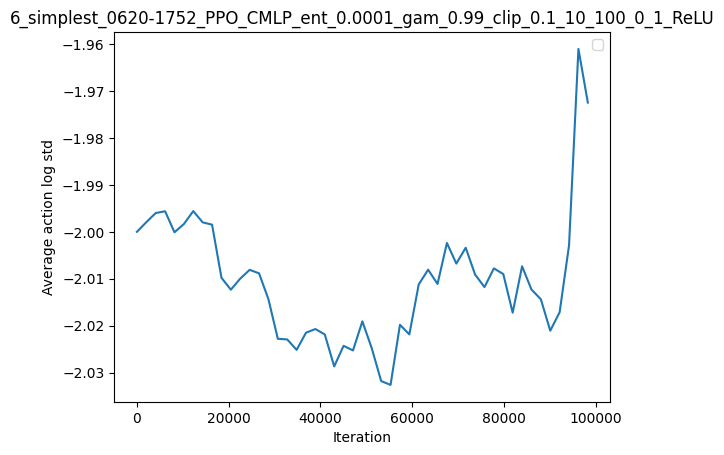

In [47]:
import matplotlib.pyplot as plt
import math
plt.plot([k*2048 for k in range(len(log_std_callback.log_stds))], [k for k in log_std_callback.log_stds])
plt.xlabel("Iteration")
plt.ylabel("Average action log std")
plt.title(model_name.split("/")[-1])
plt.legend()
plt.show()

In [36]:
model.save(model_name)

In [81]:
model.set_parameters('models\\1_simplest_0619-1445_PPO_MLP_ent_0.0001_gam_0.99_clip_0.1_10_100_0_0_ReLU')

In [82]:
M,Q,P,B,Z,D = 0, 0, 0, 0, 1, 0

In [83]:
env = BlendEnv(v = True, 
               M = M, Q = Q, P = P, B = B, Z = Z, D = D, 
               action_sample = action_sample, 
               connections = connections, 
               tau0 = tau0,
               delta0 = delta0,
               sigma = sigma,
               sigma_ub = sigma_ub,
               sigma_lb = sigma_lb,
               s_inv_lb = s_inv_lb,
               s_inv_ub = s_inv_ub,
               d_inv_lb = d_inv_lb,
               d_inv_ub = d_inv_ub,
               betaT_d = betaT_d,
               betaT_s = betaT_s,
               b_inv_ub = b_inv_ub,
               b_inv_lb = b_inv_lb)
env = Monitor(env)

In [84]:
with th.autograd.set_detect_anomaly(True):
    obs = env.reset()
    obs, obs_dict = obs
    for k in range(env.T):
        action, _ = model.predict(obs, deterministic=True)
        print("\n\n   ",reconstruct_dict(action, env.mapping_act))
        obs, reward, done, term, _ = env.step(action)
        dobs = reconstruct_dict(obs, env.mapping_obs)
        print("\n    >>     ",dobs["sources"], dobs["blenders"], dobs["demands"])
        print("   " ,reward)
        



    {'source_blend': {'s1': {'j1': 0.0}}, 'blend_demand': {'j1': {'p1': 0.0}}, 'tau': {'s1': 50.0}, 'delta': {'p1': 0.0}}
[PEN] t1; s1:			bought too much (more than supply)
Increased reward by 0.0 through tank population in s1
j1: inv: 0, in_flow_sources: 0.0, in_flow_blend: 0, out_flow_blend: 0, out_flow_demands: 0.0
Increased reward by 0 through tank population in j1
Increased reward by 0 through tank population in p1

    >>      {'s1': 10.0} {'j1': 0.0} {'p1': 0.0}
    0.0


    {'source_blend': {'s1': {'j1': 50.0}}, 'blend_demand': {'j1': {'p1': 0.0}}, 'tau': {'s1': 50.0}, 'delta': {'p1': 0.0}}
[PEN] t2; s1:			bought too much (more than supply)
s1: b: 0.4
[PEN] t2; s1:			bought too little (resulting amount less than source tank LB)
Increased reward by 0 through tank population in s1
j1: inv: 0.0, in_flow_sources: 20.0, in_flow_blend: 0, out_flow_blend: 0, out_flow_demands: 0.0
Increased reward by 0.0 through tank population in j1
Increased reward by 0 through tank population in 

In [253]:
# 0 (only once per episode)
episode_rewards = []
obs = env.reset()
obs, obs_dict = obs

In [262]:
# 1 Get first action
print(env.t)
action, _ = model.predict(obs, deterministic=True)

2


In [263]:
print(env.t)
d = reconstruct_dict(obs, env.mapping_obs)
print(d["sources"])
print(d["blenders"])
print(d["demands"])
print(d["properties"])

2
{'s1': 17.46205}
{'j1': 0.0}
{'p1': 0.0}
{'j1': {'q1': 0.0}}


In [264]:
# 2 Visualize action
print(env.t)
reconstruct_dict(action, env.mapping_act)

2


{'source_blend': {'s1': {'j1': 0.0}},
 'blend_demand': {'j1': {'p1': 30.307917}},
 'tau': {'s1': 8.731916},
 'delta': {'p1': 17.08481}}

In [265]:
# 3
# Step once: get 2nd action
print(env.t)
obs, reward, done, term, _ = env.step(action)

2


In [207]:
# 4 Visualize new state
print(env.t)
d = reconstruct_dict(obs, env.mapping_obs)
print(d["sources"])
print(d["blenders"])
print(d["demands"])
print(d["properties"])

3
{'s1': 26.193966}
{'j1': 0.0}
{'p1': 0.0}
{'j1': {'q1': 0.0}}
